In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates


import warnings
warnings.filterwarnings("ignore")
import os
import joblib

# Reading the data

In [ ]:
historical_data = pd.read_csv("multi_stock_data.csv")
historical_data.head(10)

,Price,Close,Close.1,Close.2,High,High.1,High.2,Low,Low.1,Low.2,Open,Open.1,Open.2,Volume,Volume.1,Volume.2
0,Ticker,AAPL,GOOGL,MSFT,AAPL,GOOGL,MSFT,AAPL,GOOGL,MSFT,AAPL,GOOGL,MSFT,AAPL,GOOGL,MSFT
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/4/10,6.440330982208252,15.627781867980957,23.300670623779297,6.455076781226995,15.69660225047188,23.413597655084953,6.391278499172716,15.565196892461458,23.029644599889643,6.422876697326148,15.632768673190654,23.052230580528818,493729600,78169752,38409100
3,1/5/10,6.4514665603637695,15.55896282196045,23.308216094970703,6.487879848401319,15.654961675319194,23.41361598,6.417460413781116,15.497873506395496,23.067304523334762,6.458087304295299,15.638504647580866,23.225403639687244,601904800,120067812,49749600
4,1/6/10,6.348847866,15.166740417480469,23.165164947509766,6.47704674,15.605589714679883,23.39854774423908,6.342227121682705,15.119364819246314,22.976952690417768,6.451466993,15.605589714679883,23.247977364187257,552160000,158988852,58182400
5,1/7/10,6.337108135223389,14.813666343688965,22.924253463745117,6.379841611717165,15.21012782058327,23.11246572063647,6.291065091462022,14.777512004988749,22.728512544264643,6.372318042,15.195166454339713,23.05976508251262,477131200,256315428,50559700
6,1/8/10,6.379238605499268,15.011149406433105,23.082353591918945,6.379840892833868,15.04181806856172,23.24797987913683,6.291366128938529,14.689242006526467,22.766156908360642,6.328681425,14.761303622674744,22.796271562007014,447610800,188783028,51197400
7,1/11/10,6.322966099,14.988458633422852,22.788740158081055,6.409936173343546,15.071989520179692,23.157636005212336,6.273010388314571,14.81217013010223,22.675813092378913,6.403917316228298,15.071989520179692,23.119992692681258,462229600,288227484,68754700
8,1/12/10,6.251043319702148,14.723403930664062,22.63817024230957,6.312735819,14.914901815493865,22.886610366307732,6.211921942817776,14.661565834463687,22.517714511640495,6.2952807265747985,14.902184891827291,22.698398107644106,594459600,193937868,65912100
9,1/13/10,6.339217185974121,14.638875007629395,22.84897232055664,6.347643587767648,14.671040281298277,22.976956735347766,6.142104795898216,14.309987222381789,22.593003490974386,6.255557866431915,14.37456768011763,22.78121578119982,605892000,259604136,51863500


In [ ]:
historical_data_dropped = historical_data.drop([0, 1])
historical_data_dropped.rename(columns={'Price':'Date'}, inplace=True)
filter_col_msft = ["Date"]
filter_col_aap = []
filter_col_goog = ["Date"]

filter_col_msft.extend([col for col in historical_data_dropped.columns if col.endswith('.2')])
filter_col_goog.extend([col for col in historical_data_dropped.columns if col.endswith('.1')])
filter_col_aap.extend([col for col in historical_data_dropped.columns if not col.endswith('.2') and not col.endswith('.1')])


In [ ]:
historical_data_dropped.head(2)

,Date,Close,Close.1,Close.2,High,High.1,High.2,Low,Low.1,Low.2,Open,Open.1,Open.2,Volume,Volume.1,Volume.2
2,1/4/10,6.440330982208252,15.627781867980957,23.300670623779297,6.455076781226995,15.69660225047188,23.413597655084953,6.391278499172716,15.565196892461458,23.029644599889643,6.422876697326148,15.632768673190654,23.052230580528818,493729600,78169752,38409100
3,1/5/10,6.4514665603637695,15.55896282196045,23.308216094970703,6.487879848401319,15.654961675319194,23.41361598,6.417460413781116,15.497873506395496,23.067304523334762,6.458087304295299,15.638504647580866,23.225403639687244,601904800,120067812,49749600


In [ ]:
filter_col_msft

['Date', 'Close.2', 'High.2', 'Low.2', 'Open.2', 'Volume.2']

In [ ]:
historical_data_msft = historical_data_dropped[filter_col_msft]
historical_data_msft.columns = [col[:-2] if col.endswith('.2') else col for col in historical_data_msft.columns]
historical_data_msft.head(2)

,Date,Close,High,Low,Open,Volume
2,1/4/10,23.300670623779297,23.413597655084953,23.029644599889643,23.052230580528818,38409100
3,1/5/10,23.308216094970703,23.41361598,23.067304523334762,23.225403639687244,49749600


In [ ]:
historical_data_google = historical_data_dropped[filter_col_goog]
historical_data_google.columns = [col[:-2] if col.endswith('.1') else col for col in historical_data_google.columns]
historical_data_google.head(2)

,Date,Close,High,Low,Open,Volume
2,1/4/10,15.627781867980957,15.69660225047188,15.565196892461458,15.632768673190654,78169752
3,1/5/10,15.55896282196045,15.654961675319194,15.497873506395496,15.638504647580866,120067812


In [ ]:
historical_data_apple  = historical_data_dropped[filter_col_aap]
historical_data_apple.head(2)

,Date,Close,High,Low,Open,Volume
2,1/4/10,6.440330982208252,6.455076781226995,6.391278499172716,6.422876697326148,493729600
3,1/5/10,6.4514665603637695,6.487879848401319,6.417460413781116,6.458087304295299,601904800


In [ ]:
# historical_data_msft = pd.read_csv("msft_stock_20_years.csv")
# historical_data_apple =  pd.read_csv("apple_stock_20_years.csv")
# historical_data_google =  pd.read_csv("google_stock_20_years.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
historical_data_msft.head()

,Date,Close,High,Low,Open,Volume
2,1/4/10,23.300670623779297,23.413597655084953,23.029644599889643,23.052230580528818,38409100
3,1/5/10,23.308216094970703,23.41361598,23.067304523334762,23.225403639687244,49749600
4,1/6/10,23.165164947509766,23.39854774423908,22.976952690417768,23.247977364187257,58182400
5,1/7/10,22.924253463745117,23.11246572063647,22.728512544264643,23.05976508251262,50559700
6,1/8/10,23.082353591918945,23.24797987913683,22.766156908360642,22.796271562007014,51197400


In [ ]:
historical_data_apple.head()

,Date,Close,High,Low,Open,Volume
2,1/4/10,6.440330982208252,6.455076781226995,6.391278499172716,6.422876697326148,493729600
3,1/5/10,6.4514665603637695,6.487879848401319,6.417460413781116,6.458087304295299,601904800
4,1/6/10,6.348847866,6.47704674,6.342227121682705,6.451466993,552160000
5,1/7/10,6.337108135223389,6.379841611717165,6.291065091462022,6.372318042,477131200
6,1/8/10,6.379238605499268,6.379840892833868,6.291366128938529,6.328681425,447610800


In [ ]:
historical_data_google.head()

,Date,Close,High,Low,Open,Volume
2,1/4/10,15.627781867980957,15.69660225047188,15.565196892461458,15.632768673190654,78169752
3,1/5/10,15.55896282196045,15.654961675319194,15.497873506395496,15.638504647580866,120067812
4,1/6/10,15.166740417480469,15.605589714679883,15.119364819246314,15.605589714679883,158988852
5,1/7/10,14.813666343688965,15.21012782058327,14.777512004988749,15.195166454339713,256315428
6,1/8/10,15.011149406433105,15.04181806856172,14.689242006526467,14.761303622674744,188783028


In [ ]:
historical_data_msft["Company"] = "MSFT"
historical_data_apple["Company"] = "AAPL"
historical_data_google["Company"] = "GOOG"

In [ ]:
print(historical_data_msft.columns)
print(historical_data_apple.columns)
print(historical_data_google.columns)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company'], dtype='object')
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company'], dtype='object')
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company'], dtype='object')


In [ ]:
for df in [historical_data_msft, historical_data_apple, historical_data_google]:
    if 'index' in df.columns:
        df.drop(columns='index', inplace=True)

In [ ]:
historical_data_msft = historical_data_msft.reset_index()
historical_data_apple = historical_data_apple.reset_index()
historical_data_google = historical_data_google.reset_index()

In [ ]:
historical_data = pd.concat([historical_data_msft, historical_data_apple, historical_data_google])

In [ ]:
historical_data.columns

Index(['index', 'Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Company'], dtype='object')

In [ ]:
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
historical_data.head()

,index,Date,Close,High,Low,Open,Volume,Company
0,2,2010-01-04,23.300670623779297,23.413597655084953,23.029644599889643,23.052230580528818,38409100,MSFT
1,3,2010-01-05,23.308216094970703,23.41361598,23.067304523334762,23.225403639687244,49749600,MSFT
2,4,2010-01-06,23.165164947509766,23.39854774423908,22.976952690417768,23.247977364187257,58182400,MSFT
3,5,2010-01-07,22.924253463745117,23.11246572063647,22.728512544264643,23.05976508251262,50559700,MSFT
4,6,2010-01-08,23.082353591918945,23.24797987913683,22.766156908360642,22.796271562007014,51197400,MSFT


In [ ]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11322 entries, 0 to 3773
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    11322 non-null  int64         
 1   Date     11322 non-null  datetime64[ns]
 2   Close    11322 non-null  object        
 3   High     11322 non-null  object        
 4   Low      11322 non-null  object        
 5   Open     11322 non-null  object        
 6   Volume   11322 non-null  object        
 7   Company  11322 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 796.1+ KB


In [ ]:
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
historical_data[cols_to_convert] = historical_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Optional: reset index
historical_data = historical_data.reset_index(drop=True)

# Final check
print(historical_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11322 entries, 0 to 11321
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    11322 non-null  int64         
 1   Date     11322 non-null  datetime64[ns]
 2   Close    11322 non-null  float64       
 3   High     11322 non-null  float64       
 4   Low      11322 non-null  float64       
 5   Open     11322 non-null  float64       
 6   Volume   11322 non-null  int64         
 7   Company  11322 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 707.8+ KB
None


# Initial EDA and visualization

### Question : Is there a consistent relationship between the magnitude of daily price changes and trading volume

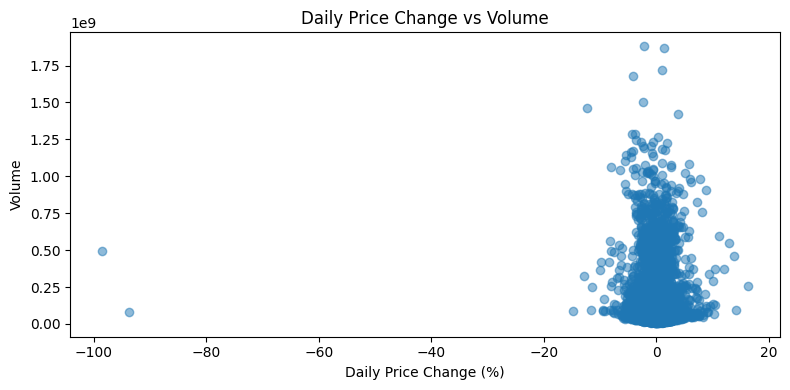

In [ ]:

historical_data['Price_Change'] = historical_data['Close'].pct_change() * 100

plt.figure(figsize=(8, 4))
plt.scatter(
    historical_data['Price_Change'],
    historical_data['Volume'],
    alpha=0.5
)
plt.xlabel('Daily Price Change (%)')
plt.ylabel('Volume')
plt.title('Daily Price Change vs Volume')
plt.tight_layout()
plt.show()




###  **Analysis of the Daily Price Change vs Volume Plot (2010-01-04 to 2024-12-31)**

1. **Plot Overview:**

   * The scatter plot illustrates the relationship between daily price changes (in percentage) and trading volume for three major companies: Google, Apple, and Microsoft.
   * The x-axis represents the daily price change percentage, ranging from approximately -100% to +20%.
   * The y-axis shows the trading volume, ranging from 0 to approximately $1.75 \times 10^9$.

2. **Data Distribution Analysis:**

   * The bulk of the data points are concentrated between -20% to +20% daily price change.
   * Trading volumes are generally clustered around the lower to middle volume ranges, indicating that extreme price changes do not typically coincide with exceptionally high trading volumes.

3. **Outliers Analysis:**

   * There are two prominent outliers with extremely negative price changes (near -100%) and relatively lower volumes. These points likely indicate significant market events or stock splits.
   * On the positive side, there are several outliers with relatively high trading volumes, possibly representing days with major news releases, earnings reports, or significant market movements.

4. **Volume-Price Change Correlation:**

   * The plot shows a higher density of points around the 0% price change, suggesting that most trading days experience minor price changes regardless of volume.
   * There is no strong linear correlation evident between volume and price change percentage. However, the presence of high-volume spikes during periods of low price changes may indicate institutional trading activity or other significant events.

5. **Implications:**

   * Identifying such outliers can provide valuable insights for risk management and trading strategies.
   * Further analysis, such as time-series breakdowns or event tagging, could reveal underlying factors influencing these anomalies.



## Why OBV Helps

On-Balance Volume (OBV) was chosen because it:

- **Accumulates volume** when the market closes higher (bullish signal).  
- **Subtracts volume** when the market closes lower (bearish signal).  
- **Ignores neutral days**, carrying forward the previous OBV level when price is unchanged.  

This transforms noisy raw volume into a **smooth, cumulative series** that highlights the net flow of “smart money”.

In [ ]:
# Calculate On-Balance Volume (OBV)
def draw_company_graph(historical_data, company):


    # Filter by company
    historical_data = historical_data[historical_data["Company"] == company]

    # Sort by date to ensure proper plotting
    historical_data = historical_data.sort_values('Date')

    # Initialize OBV column
    historical_data['OBV'] = 0

    # Calculate OBV
    for i in range(1, len(historical_data)):
        if historical_data['Close'].iloc[i] > historical_data['Close'].iloc[i - 1]:
            historical_data['OBV'].iloc[i] = historical_data['OBV'].iloc[i - 1] + historical_data['Volume'].iloc[i]
        elif historical_data['Close'].iloc[i] < historical_data['Close'].iloc[i - 1]:
            historical_data['OBV'].iloc[i] = historical_data['OBV'].iloc[i - 1] - historical_data['Volume'].iloc[i]
        else:
            historical_data['OBV'].iloc[i] = historical_data['OBV'].iloc[i - 1]

    # Calculate Volume Moving Average (e.g., 20-day)
    historical_data['Volume_MA_20'] = historical_data['Volume'].rolling(window=20).mean()

    # Plotting the data
    plt.figure(figsize=(14, 10))

    # Plot 1: Price and OBV
    plt.subplot(3, 1, 1)
    plt.plot(historical_data['Date'], historical_data['Close'], label='Close Price', color='blue')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show tick every 2 years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.title('Price and On-Balance Volume (OBV)')
    plt.legend(loc='upper left')
    plt.twinx()
    plt.plot(historical_data['Date'], historical_data['OBV'], label='OBV', color='orange')
    plt.legend(loc='upper right')



    # Plot 2: Volume and Volume Moving Average
    plt.subplot(3, 1, 2)
    plt.bar(historical_data['Date'], historical_data['Volume'], label='Volume', color='gray', alpha=0.7)
    plt.plot(historical_data['Date'], historical_data['Volume_MA_20'], label='20-Day Volume MA', color='red')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.title('Volume and Volume Moving Average')
    plt.legend()



    # Plot 3: Price with Volume Spikes
    plt.subplot(3, 1, 3)
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.plot(historical_data['Date'], historical_data['Close'], label='Close Price', color='blue')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2.bar(historical_data['Date'], historical_data['Volume'], label='Volume', color='gray', alpha=0.3)
    ax2.set_ylabel('Volume', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    ax1.xaxis.set_major_locator(mdates.YearLocator(2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.title('Price with Volume Spikes')


    plt.tight_layout()
    plt.show()


#### APPLE

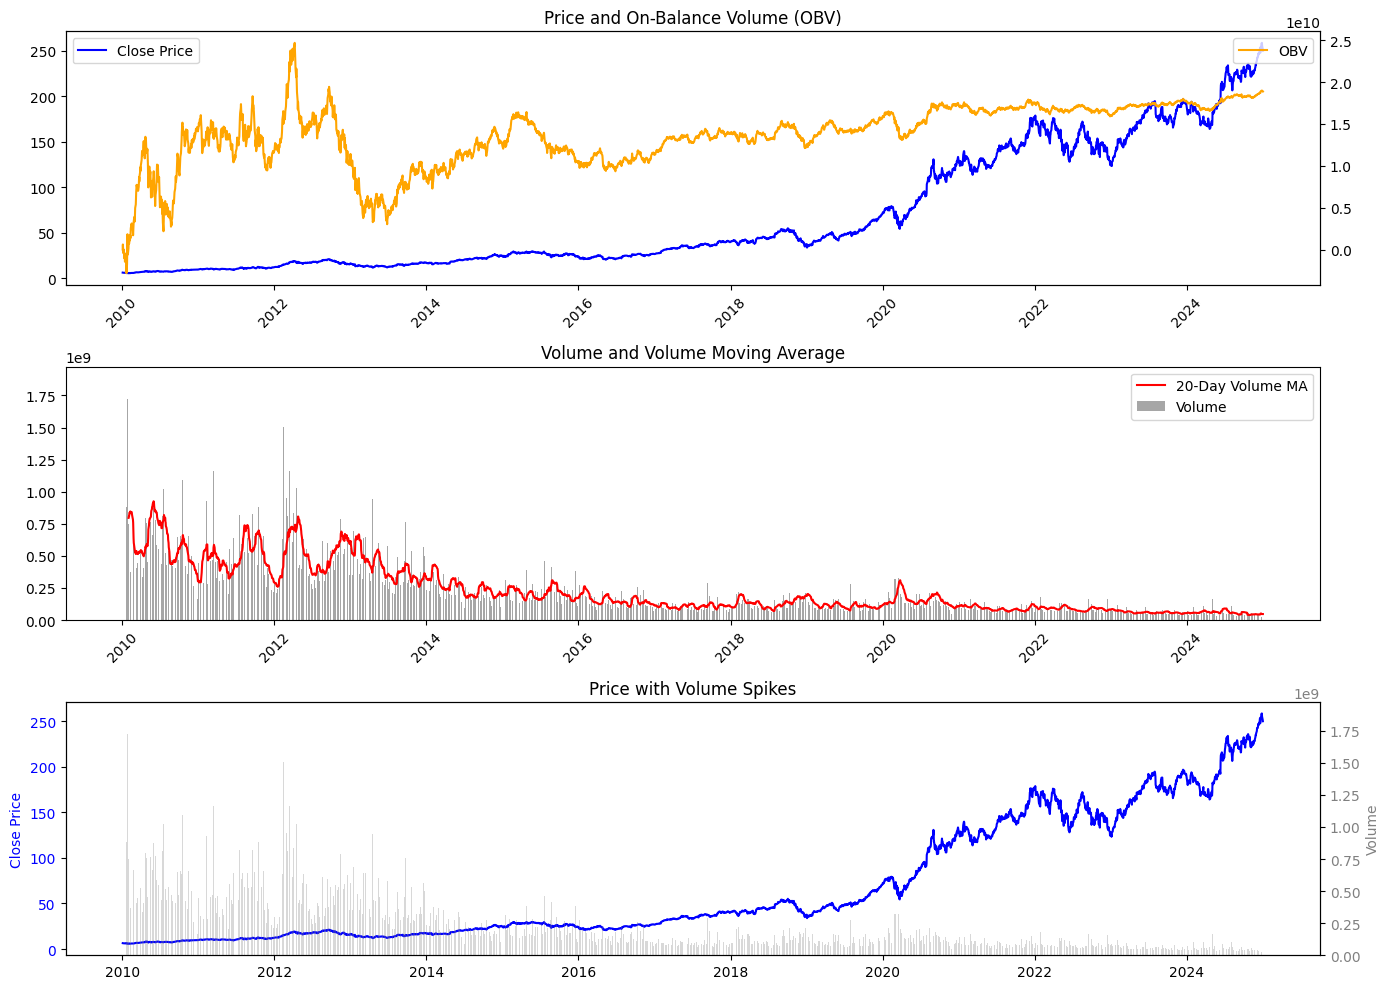

In [ ]:
draw_company_graph(historical_data, 'AAPL')


###  **Analysis of Apple Stock Data (2010 - 2024)**

### **1. Price and On-Balance Volume (OBV) Analysis:**

* The first subplot shows the relationship between the closing price (blue) and the On-Balance Volume (OBV) (orange).
* The closing price exhibits a significant upward trend, particularly after 2019, aligning with a surge in tech stocks.
* The OBV shows a steady upward trajectory, indicating a consistent accumulation of volume over time. This suggests that buyers have been dominant throughout the period, pushing the price higher.
* The OBV line flattens during periods of price consolidation and rises sharply during price rallies, indicating strong volume support during uptrends.

### **2. Volume and Volume Moving Average Analysis:**

* The second subplot shows the daily volume as gray bars and the 20-day volume moving average as a red line.
* Noticeable spikes in volume occur around key market events, such as earnings releases, major news announcements, or significant market corrections.
* Overall, the volume trend has been decreasing steadily over the years. This could indicate reduced speculative trading or a transition from high-frequency trading to more stable, long-term holdings.
* The volume moving average smooths out short-term fluctuations and highlights persistent volume trends. It remains relatively flat in recent years, indicating a stable trading environment.

### **3. Price with Volume Spikes Analysis:**

* The third subplot overlays the closing price with volume spikes.
* The price trend follows a strong upward movement with significant price appreciation after the 2020 period, coinciding with broader market recovery and the tech boom.
* The volume spikes are more pronounced in the earlier years, particularly around the 2010-2014 period, likely due to heightened volatility and investor activity.
* Despite rising prices, recent years show lower relative volume spikes, suggesting a more mature, less speculative trading environment.

### **Summary:**

* The OBV trend aligns well with the price trend, indicating that volume has been a strong supporting factor in Apple’s price appreciation.
* Decreasing volume over the years may indicate a shift from speculative trading to more stable, long-term investment.
* The price shows strong support levels around 2018-2019, followed by a rapid acceleration in 2020 and beyond, driven by tech market dominance.




#### MICROSOFT

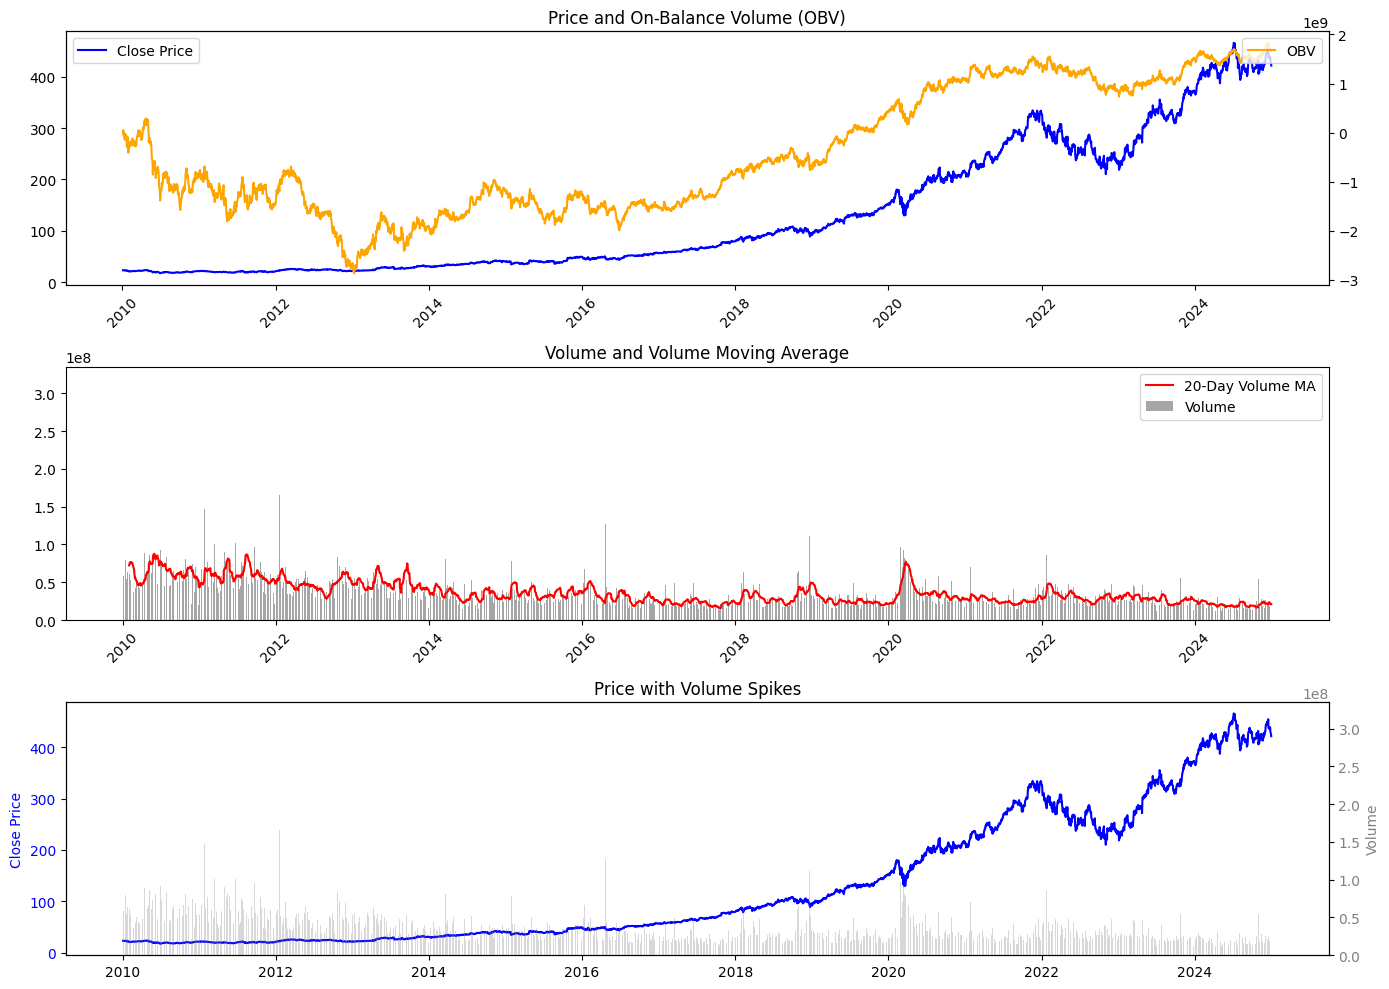

In [ ]:
draw_company_graph(historical_data, 'MSFT')



###  **Analysis of Microsoft Stock Data (2010 - 2024)**

### **1. Price and On-Balance Volume (OBV) Analysis:**

* The first subplot displays the closing price (blue) and the On-Balance Volume (OBV) (orange).
* The closing price shows a strong upward trend, particularly from 2016 onwards, indicating a significant price rally driven by strong financial performance and market positioning.
* OBV follows a steady upward trend, reinforcing that trading volume is consistently supporting the price increases. This upward OBV movement indicates sustained accumulation by institutional investors and long-term holders.
* Notice the flattening of OBV in recent years, despite continued price increases. This suggests that while the price is still rising, the trading volume has not significantly increased, indicating potential divergence and reduced buying pressure.

### **2. Volume and Volume Moving Average Analysis:**

* The second subplot presents the daily trading volume as gray bars and the 20-day volume moving average as a red line.
* The volume shows distinct spikes, especially in the 2010-2014 period, suggesting high volatility and active trading.
* After 2016, volume volatility decreases, and the 20-day moving average stabilizes, indicating more consistent trading activity with fewer extreme spikes.
* Notable volume spikes occur during market corrections, earnings announcements, and major product or service releases. The spikes in 2020 align with the COVID-19 pandemic and the surge in tech stock trading.
* The volume moving average remains relatively flat in recent years, indicating stable but not significantly increasing trading activity despite the price rally.

### **3. Price with Volume Spikes Analysis:**

* The third subplot overlays the closing price with volume spikes.
* The price shows a strong, consistent uptrend from 2016 onwards, reflecting Microsoft's business growth, cloud service dominance, and successful financial performance.
* Volume spikes align with periods of sharp price corrections and rapid price rallies, particularly noticeable around market corrections (e.g., 2020 pandemic-induced market drop).
* Despite the rising price, recent years show a reduction in trading volume relative to historical peaks, indicating that fewer shares are being traded as the price climbs, possibly due to long-term holding by institutional investors.

### **Summary:**

* Microsoft's price trend is strongly positive, with a significant rally post-2016, driven by business expansion and strategic acquisitions.
* OBV indicates steady accumulation throughout the observed period, though recent divergence suggests potential waning momentum in trading volume.
* Volume analysis shows decreasing volatility over time, indicating more stable and consistent trading activity in recent years.
* Potential divergence between rising price and flat volume could indicate weakening buying pressure, warranting closer monitoring of volume trends relative to price movements.



#### GOOGLE

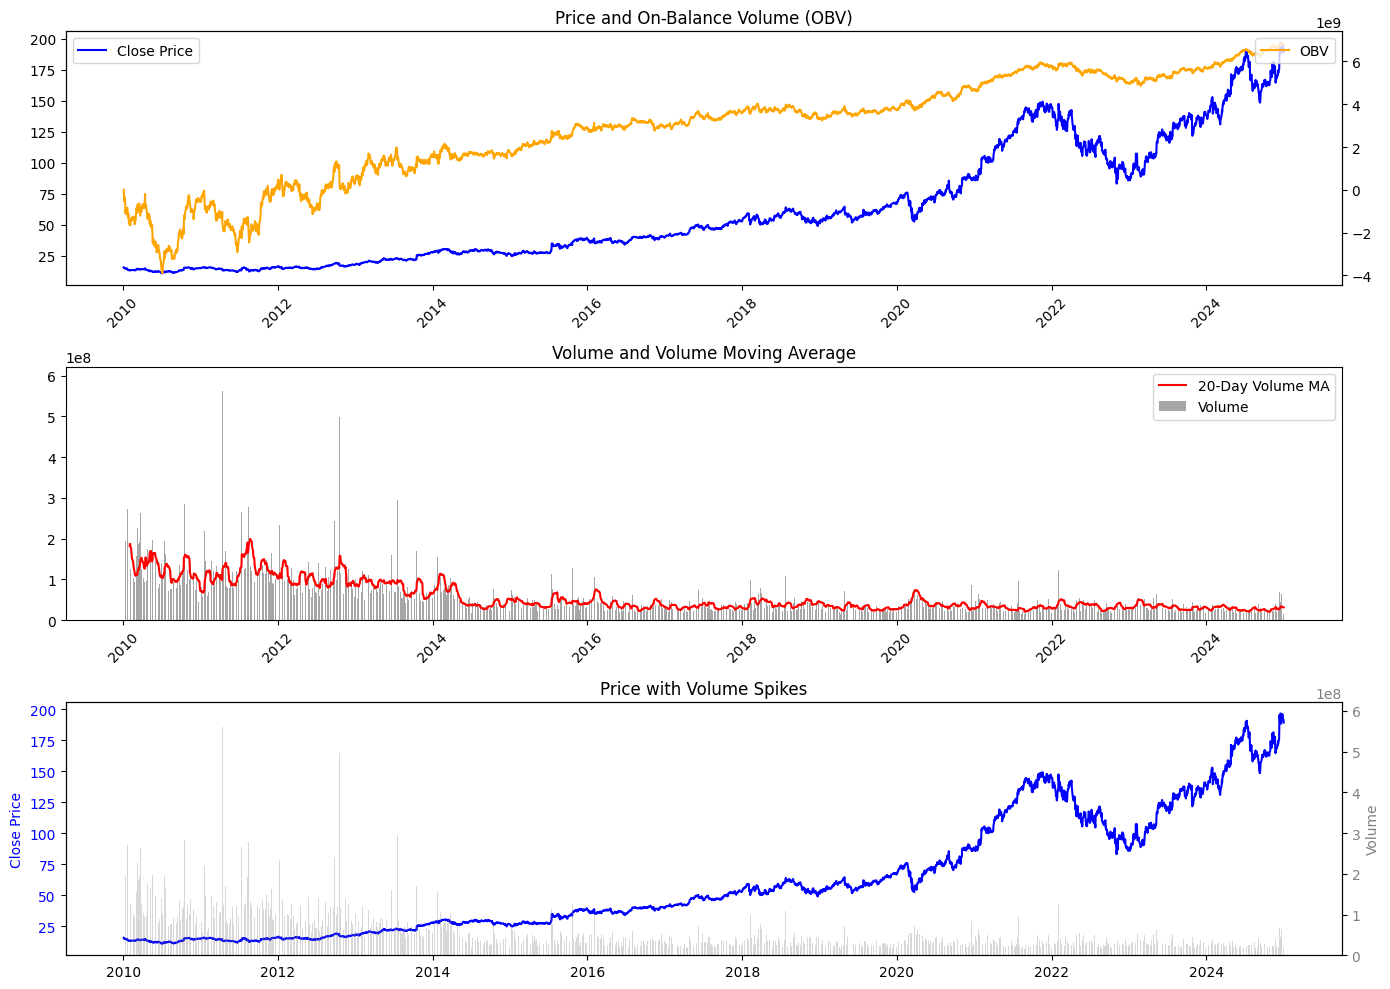

In [ ]:
draw_company_graph(historical_data, 'GOOG')



### **Analysis of Google (Alphabet) Stock Data (2010 - 2024)**

### **1. Price and On-Balance Volume (OBV) Analysis:**

* The first subplot shows the relationship between the closing price (blue) and the On-Balance Volume (OBV) (orange).
* The closing price displays a steady upward trend, with significant acceleration after 2020, likely driven by the tech boom and strong financial performance.
* The OBV line follows a similar trajectory, indicating strong volume accumulation throughout the period. This consistent OBV uptrend suggests continuous institutional buying and long-term holding by investors.
* Notably, OBV remains relatively flat during certain price consolidation phases, especially around 2016-2018, indicating neutral buying pressure despite price stability.

### **2. Volume and Volume Moving Average Analysis:**

* The second subplot presents the daily volume as gray bars and the 20-day volume moving average as a red line.
* Early periods (2010-2012) exhibit higher volume volatility, indicating speculative trading activity and potential market corrections.
* The volume steadily decreases after 2014, with only occasional spikes, indicating more controlled and less volatile trading.
* The 20-day moving average smooths out volume fluctuations, showing a declining trend, indicating a transition to more stable, less speculative trading activity.
* The volume trend shows a slight uptick after 2020, aligning with the increased focus on tech stocks during the pandemic and subsequent market rally.

### **3. Price with Volume Spikes Analysis:**

* The third subplot overlays the closing price with volume spikes.
* The price shows a strong upward trajectory from 2016 onwards, with an aggressive rally after 2020.
* Volume spikes are more noticeable in earlier years (2010-2012), likely driven by market corrections, stock splits, or major news releases.
* Despite the significant price appreciation post-2020, volume spikes remain relatively muted, suggesting that the price increase is primarily driven by institutional holding rather than speculative trading.

### **Summary:**

* Google's stock exhibits a strong long-term uptrend, with accelerated price gains after 2020, driven by tech market strength.
* The OBV trend reinforces the price trend, indicating sustained accumulation by long-term investors.
* Volume analysis shows a decline in speculative trading activity, with fewer volume spikes in recent years, indicating more stable investor behavior.
* Despite rising prices, the reduced volume spikes suggest that the price rally is more likely driven by institutional accumulation rather than retail speculation.





### Key Common Themes

- **OBV confirms trend strength** when it rises with price, warns of weakness when it diverges.  
- **Volume MA** smooths day-to-day noise and highlights surges tied to big events.  
- **Volume spikes on pullbacks** frequently mark capitulation points—useful for timing entries.

These insights illustrate why we moved from raw volume analysis to a **cumulative, price-directional indicator** (OBV) combined with smoothed volume: to capture the underlying flow of “smart money” behind each stock’s move.  

# Model Training (LSTM and RNN)

In [ ]:
historical_data.head()

,index,Date,Close,High,Low,Open,Volume,Company,Price_Change
0,2,2010-01-04,23.300671,23.413598,23.029645,23.052231,38409100,MSFT,NaN
1,3,2010-01-05,23.308216,23.413616,23.067305,23.225404,49749600,MSFT,0.032383
2,4,2010-01-06,23.165165,23.398548,22.976953,23.247977,58182400,MSFT,-0.613737
3,5,2010-01-07,22.924253,23.112466,22.728513,23.059765,50559700,MSFT,-1.039973
4,6,2010-01-08,23.082354,23.247980,22.766157,22.796272,51197400,MSFT,0.689663


In [ ]:
#Sort & Select Relevant Columns
historical_data.sort_values(['Company', 'Date'], inplace=True)
historical_data = historical_data[['Date', 'Close', 'Company']]


In [ ]:
# Constants
# Since the data we have is a daily sata, we choose one-year window (length of each input sequence)
SEQ_LENGTH = 365
MODEL_DIR = 'models/'

os.makedirs(MODEL_DIR, exist_ok=True)

#### Sequence Creation :

What:
- Slides a window of length seq_length(365) over the 1D array series.
- Gathers each window as an input X, and the next value as target y.

Why:
- LSTM/RNN models need fixed-length sequences of past values to predict the next value.

In [ ]:
def create_sequences(series, seq_length=SEQ_LENGTH):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

#### Preprocessing Function
Steps:
1.	Scale Close prices to [0,1] for neural network stability.
2.	Create sequences & targets.
3.	Reshape into (samples, timesteps, features) for Keras.
4.	Split 80/20 train/test by time (no shuffling).

Why:

•	Scaling accelerates convergence and prevents dominance of large values.<br>
•	Time-based split preserves chronological order for realistic evaluation.

In [ ]:
def preprocess_company_data(company_df):
    """
    Scale the Close prices and create sequences for a company's data.
    """
    scaler = MinMaxScaler()
    company_df['Scaled_Close'] = scaler.fit_transform(company_df[['Close']])
    X, y = create_sequences(company_df['Scaled_Close'].values)
    X = X.reshape((X.shape[0], SEQ_LENGTH, 1))

    # Sequential split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test, scaler

#### LSTM Model Builder
•	A 64-unit LSTM digests the input sequence into a single hidden state, which a Dense neuron then converts into the next-day price prediction.  
•	Uses adam optimizer + MSE loss.


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


Here we swap out the LSTM for a straightforward RNN layer with the same 64 units, keeping the optimizer and loss function identical. This simple RNN serves as our baseline—letting us measure how much the LSTM’s extra gating boosts accuracy and how their training speeds compare.

In [ ]:
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
def save_trained_model(model, company_name, model_type):
    filename = f"{MODEL_DIR}/{company_name}_{model_type}_model.h5"
    model.save(filename)
    print(f"✅ Saved {model_type.upper()} model for {company_name} at {filename}")

#### Main Training Function

The 'train_models_for_company' routine orchestrates the entire workflow : beginning with data scaling and sequence generation, followed by the instantiation and training of both the LSTM and RNN architectures for twenty epochs each, and concluding with the serialization of the trained model weights alongside the fitted scaler. By encapsulating preprocessing, model construction, training, validation, and persistence in a single, parameterized function, this design promotes consistency, reduces repetitive code, and streamlines the generation of production‐ready models for each company.  

In [ ]:

def train_models_for_company(company_name, company_df):
    print(f"\n🔵 Training models for {company_name}...")

    X_train, X_test, y_train, y_test, scaler = preprocess_company_data(company_df)
    input_shape = (SEQ_LENGTH, 1)

    # Train LSTM
    lstm_model = build_lstm_model(input_shape)
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    save_trained_model(lstm_model, company_name, 'lstm')

    # Train RNN
    rnn_model = build_rnn_model(input_shape)
    rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    save_trained_model(rnn_model, company_name, 'rnn')

    # Save scaler
    joblib.dump(scaler, f'models/{company_name}_scaler.save')
    print(f"✅ Saved Scaler for {company_name}")

    return scaler


Here we take our 'train_models_for_company' function and run it for every ticker in the dataset. We loop over each unique company name, slice out its data, and hand it to 'train_models_for_company'. That call scales the data, builds and trains both LSTM and RNN models for twenty epochs, and saves everything—including the fitted scaler. We keep track of each returned scaler in a simple dictionary keyed by company. When the loop finishes, you’ve got all models trained and persisted, plus a map of scalers for any future inverse‐scaling needs : no extra wiring required.

In [ ]:
def train_all_companies(dataframe):
    company_scalers = {}

    for company in dataframe['Company'].unique():
        company_df = dataframe[dataframe['Company'] == company].copy()
        scaler = train_models_for_company(company, company_df)
        company_scalers[company] = scaler  # Optional: keep track of scalers

    return company_scalers

We loop over each company again, fit a fresh 'MinMaxScaler' on its Close series, add a new 'Scaled_Close' column, and append that slice to a list. Once every company’s scaled data is in there, we 'pd.concat' the list back into one DataFrame and re-sort by company and date. The result is 'scaled_df', a clean, chronologically ordered DataFrame of scaled closing prices for every company, perfect for any cross ticker analysis or combined modeling.  

In [ ]:
scaled_data_list = []

for company in historical_data['Company'].unique():
    company_df = historical_data[historical_data['Company'] == company].copy()

    scaler = MinMaxScaler()
    company_df['Scaled_Close'] = scaler.fit_transform(company_df[['Close']])

    scaled_data_list.append(company_df)

# Concatenate all companies back into one dataframe
scaled_df = pd.concat(scaled_data_list, axis=0)

# Sort again just to be safe
scaled_df = scaled_df.sort_values(['Company', 'Date']).reset_index(drop=True)

# Check
scaled_df.head()


,Date,Close,Company,Scaled_Close
0,2010-01-04,6.440331,AAPL,0.002613
1,2010-01-05,6.451467,AAPL,0.002657
2,2010-01-06,6.348848,AAPL,0.002251
3,2010-01-07,6.337108,AAPL,0.002204
4,2010-01-08,6.379239,AAPL,0.002371


In [ ]:
company_scalers = train_all_companies(scaled_df)


🔵 Training models for AAPL...


✅ Saved LSTM model for AAPL at models//AAPL_lstm_model.h5


✅ Saved RNN model for AAPL at models//AAPL_rnn_model.h5
✅ Saved Scaler for AAPL

🔵 Training models for GOOG...


✅ Saved LSTM model for GOOG at models//GOOG_lstm_model.h5


✅ Saved RNN model for GOOG at models//GOOG_rnn_model.h5
✅ Saved Scaler for GOOG

🔵 Training models for MSFT...


✅ Saved LSTM model for MSFT at models//MSFT_lstm_model.h5


✅ Saved RNN model for MSFT at models//MSFT_rnn_model.h5
✅ Saved Scaler for MSFT


## Graphs

We start by retrieving our saved LSTM and RNN models from the 'models/' directory. Given a company name, this function uses Keras’s 'load_model' to instantiate each network in memory, so they’re ready to generate predictions.

In [ ]:
def load_models(company_name, model_dir='models/'):
    lstm_model = load_model(f'{model_dir}/{company_name}_lstm_model.h5')
    rnn_model = load_model(f'{model_dir}/{company_name}_rnn_model.h5')
    return lstm_model, rnn_model

Next, we reconstruct the exact input format the models saw during training. We load the company’s saved 'MinMaxScaler', apply it to the raw Close prices, and then build overlapping windows of length 365 days. Those windows become our 'X_test' array, and the corresponding next-day prices form 'y_test'.

In [ ]:
def prepare_company_test_data(company_df, company_name, seq_length=365, model_dir='models/'):
    import joblib
    # Load saved scaler
    scaler = joblib.load(f'{model_dir}/{company_name}_scaler.save')

    # Apply scaling
    company_df['Scaled_Close'] = scaler.transform(company_df[['Close']])

    # Create sequences
    X, y = create_sequences(company_df['Scaled_Close'].values, seq_length)
    X = X.reshape((X.shape[0], seq_length, 1))

    # Sequential split
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_test, y_test, scaler


With models and test inputs in hand, we call each model's '.predict()' method to produce scaled forecasts. We then reshape those outputs alongside the true targets, and finally reverse the MinMax scaling so we can compare predictions in **actual price** space rather than normalized units.

In [ ]:
def predict_and_inverse_transform(lstm_model, rnn_model, X_test, y_test, scaler):
    lstm_preds_scaled = lstm_model.predict(X_test)
    rnn_preds_scaled = rnn_model.predict(X_test)

    # Reshape
    y_test = y_test.reshape(-1, 1)
    lstm_preds_scaled = lstm_preds_scaled.reshape(-1, 1)
    rnn_preds_scaled = rnn_preds_scaled.reshape(-1, 1)

    # Inverse transform
    actual_prices = scaler.inverse_transform(y_test).flatten()
    lstm_preds_actual = scaler.inverse_transform(lstm_preds_scaled).flatten()
    rnn_preds_actual = scaler.inverse_transform(rnn_preds_scaled).flatten()

    return y_test.flatten(), lstm_preds_scaled.flatten(), rnn_preds_scaled.flatten(), actual_prices, lstm_preds_actual, rnn_preds_actual


Visualizing the first 100 test samples entirely in their scaled form.

In [ ]:

def plot_scaled_predictions(y_test, lstm_preds_scaled, rnn_preds_scaled, company_name):
    plt.figure(figsize=(14,7))
    plt.plot(y_test[:100], label='Actual Scaled Prices', color='blue', linewidth=2)
    plt.plot(lstm_preds_scaled[:100], label='LSTM Predicted Scaled Prices', color='green', linestyle='--')
    plt.plot(rnn_preds_scaled[:100], label='RNN Predicted Scaled Prices', color='orange', linestyle='--')
    plt.title(f'{company_name}: Scaled Predictions (First 100 Samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Scaled Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


We repeat the visualization, this time after converting everything back to real dollar amounts. Overlaying actual versus forecasted prices in their native units makes it easy to assess real world prediction accuracy and to spot any systematic under or over shooting by either model.

In [ ]:

def plot_unscaled_predictions(actual_prices, lstm_preds_actual, rnn_preds_actual, company_name):
    plt.figure(figsize=(14,7))
    plt.plot(actual_prices[:100], label='Actual Prices', color='blue', linewidth=2)
    plt.plot(lstm_preds_actual[:100], label='LSTM Predicted Prices', color='green', linestyle='--')
    plt.plot(rnn_preds_actual[:100], label='RNN Predicted Prices', color='orange', linestyle='--')
    plt.title(f'{company_name}: Actual Price Predictions (First 100 Samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


This ties it all together: it loads models, prepares the test split, runs predictions, and calls both plotting routines in sequence all with a single invocation. A simple print statement confirms which company is being processed.

In [ ]:
def plot_all_predictions_for_company(company_name, dataframe, model_dir='models/'):
    print(f"\n📈 Plotting for {company_name}...")

    lstm_model, rnn_model = load_models(company_name, model_dir)
    company_df = dataframe[dataframe['Company'] == company_name].copy()

    X_test, y_test, scaler = prepare_company_test_data(company_df, company_name)
    y_test, lstm_preds_scaled, rnn_preds_scaled, actual_prices, lstm_preds_actual, rnn_preds_actual = predict_and_inverse_transform(
        lstm_model, rnn_model, X_test, y_test, scaler
    )

    plot_scaled_predictions(y_test, lstm_preds_scaled, rnn_preds_scaled, company_name)
    plot_unscaled_predictions(actual_prices, lstm_preds_actual, rnn_preds_actual, company_name)


In [ ]:
def plot_all_companies(dataframe, model_dir='models/'):
    for company in dataframe['Company'].unique():
        plot_all_predictions_for_company(company, dataframe, model_dir)


📈 Plotting for AAPL...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


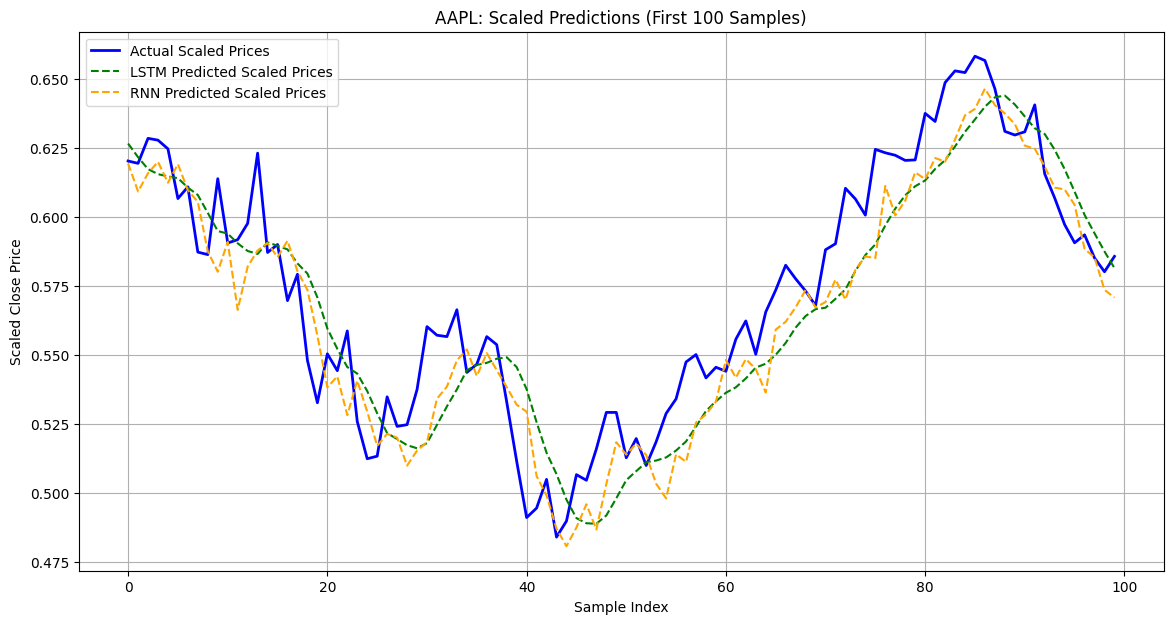

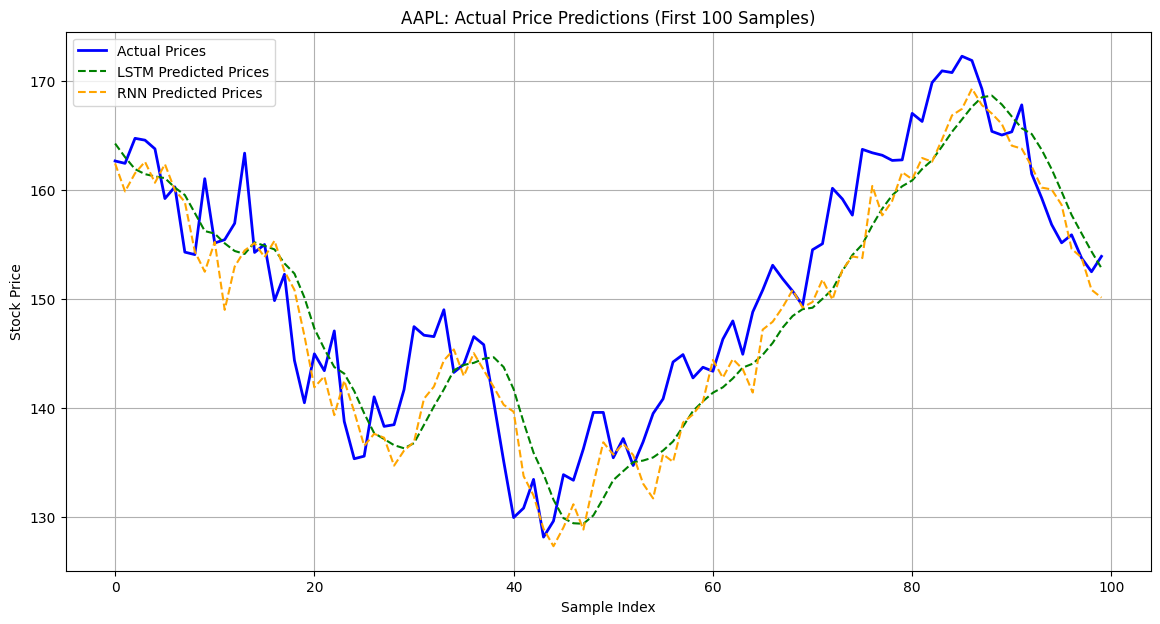

In [ ]:
plot_all_predictions_for_company('AAPL', scaled_df)



📈 Plotting for AAPL...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


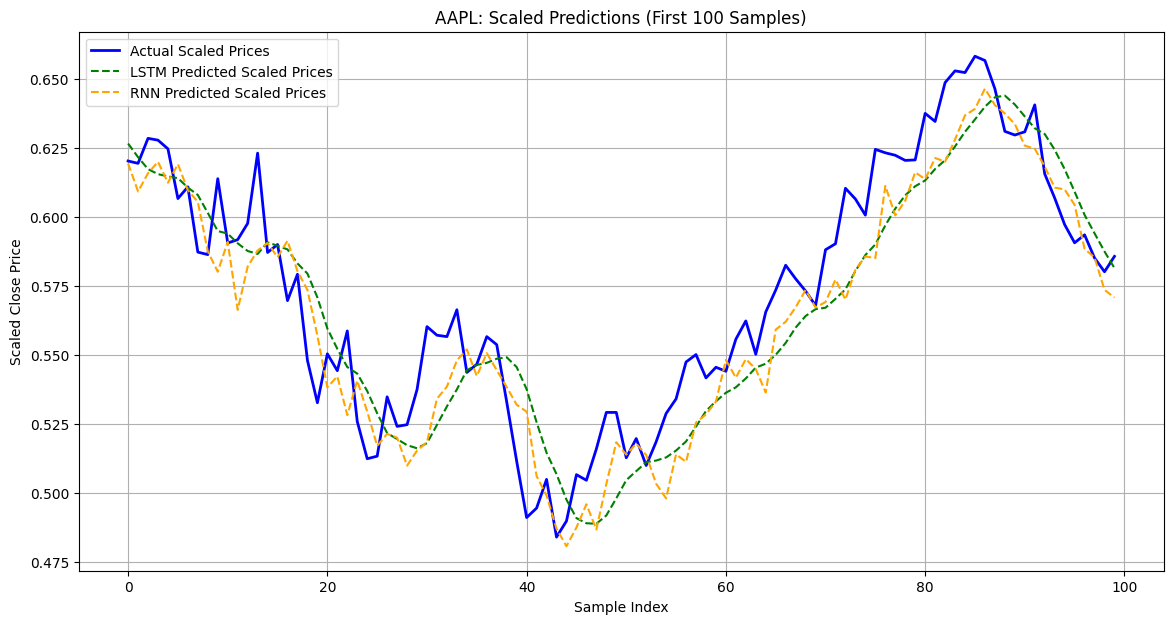

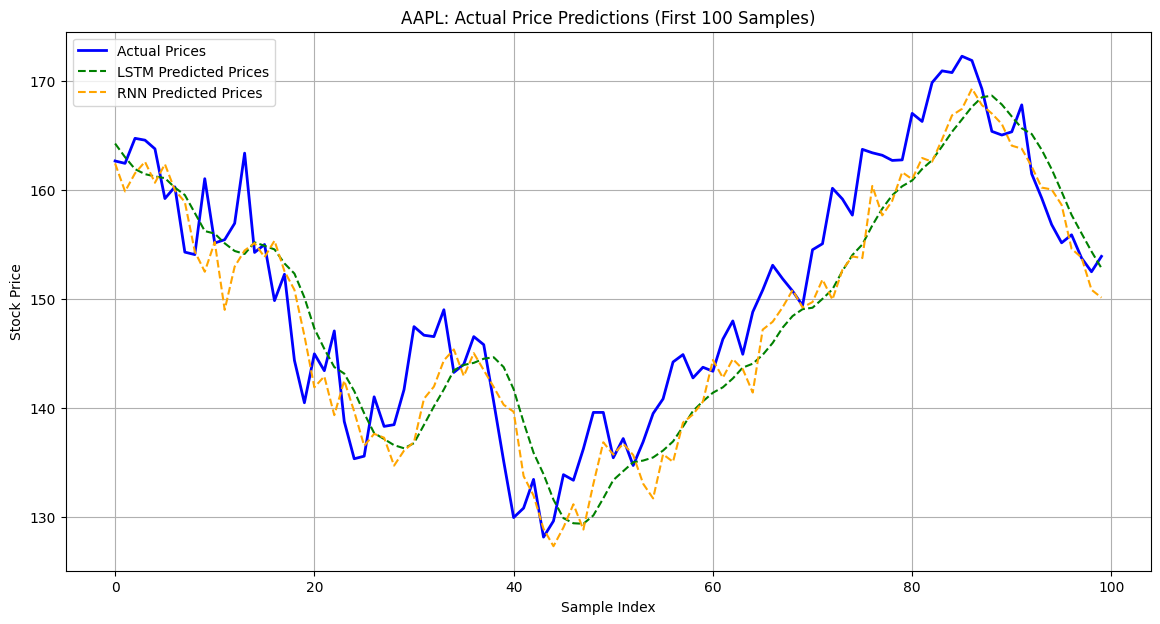


📈 Plotting for GOOG...


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


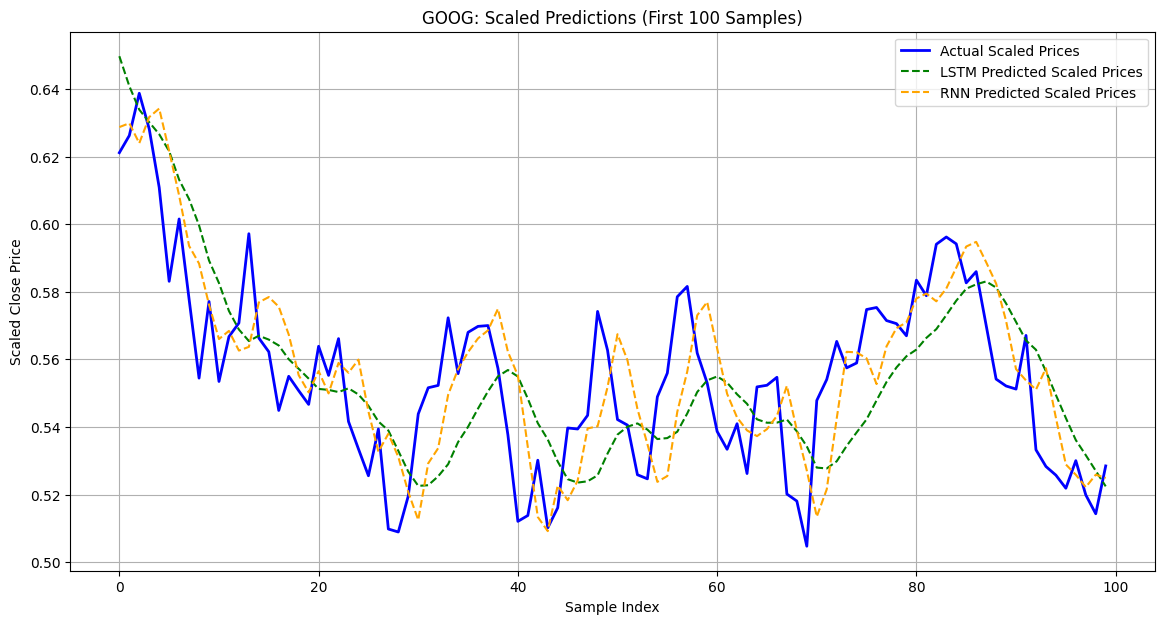

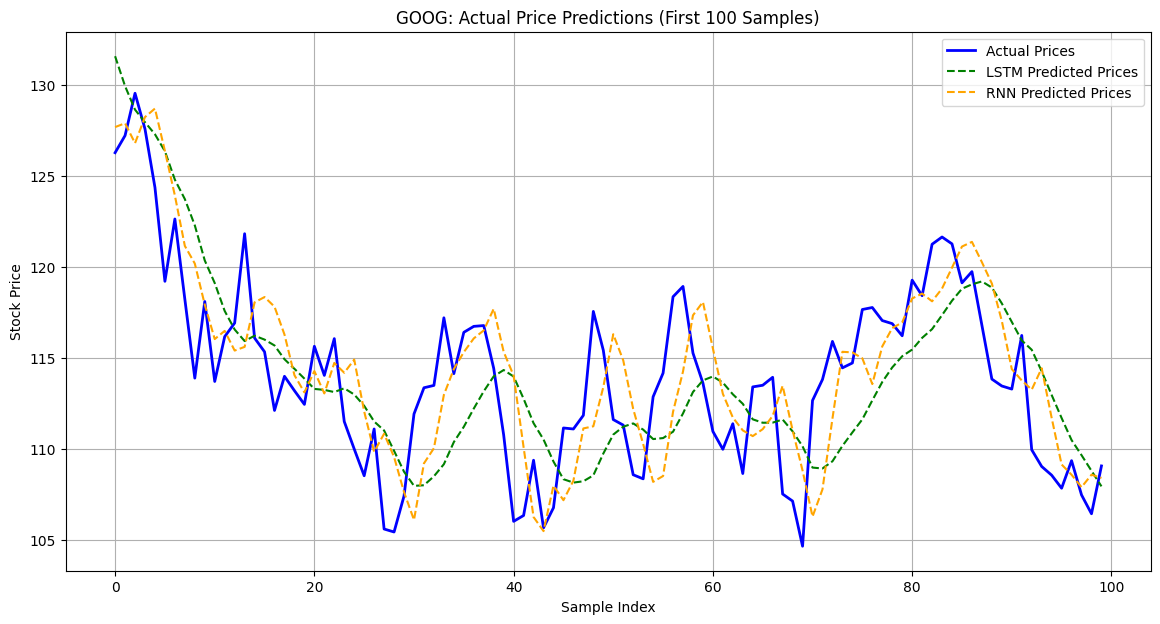


📈 Plotting for MSFT...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


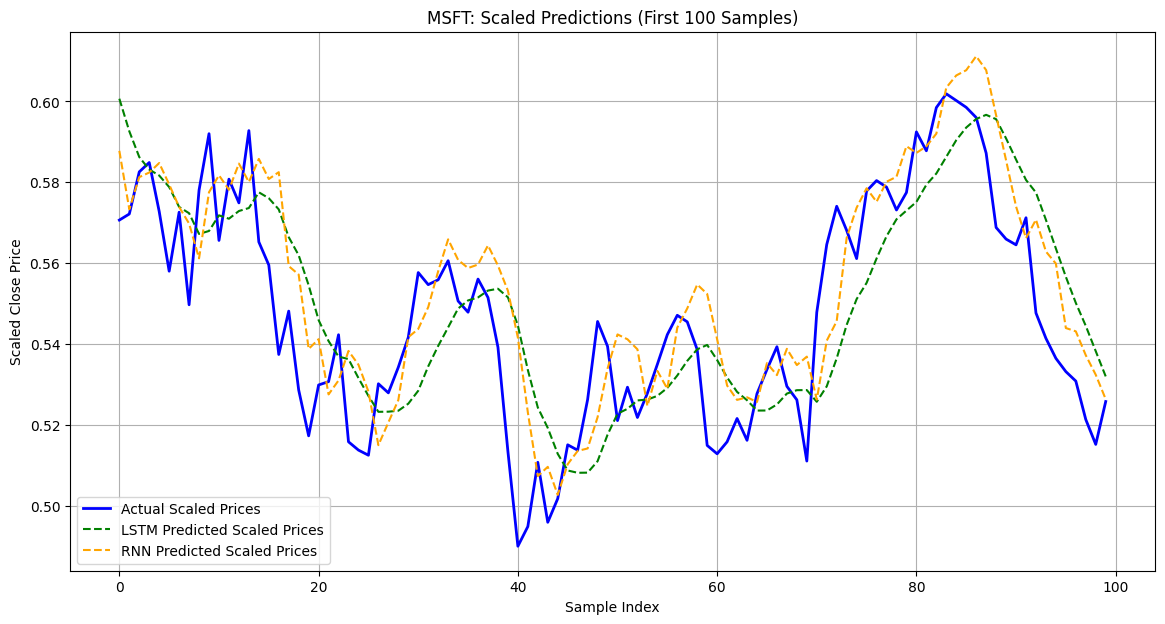

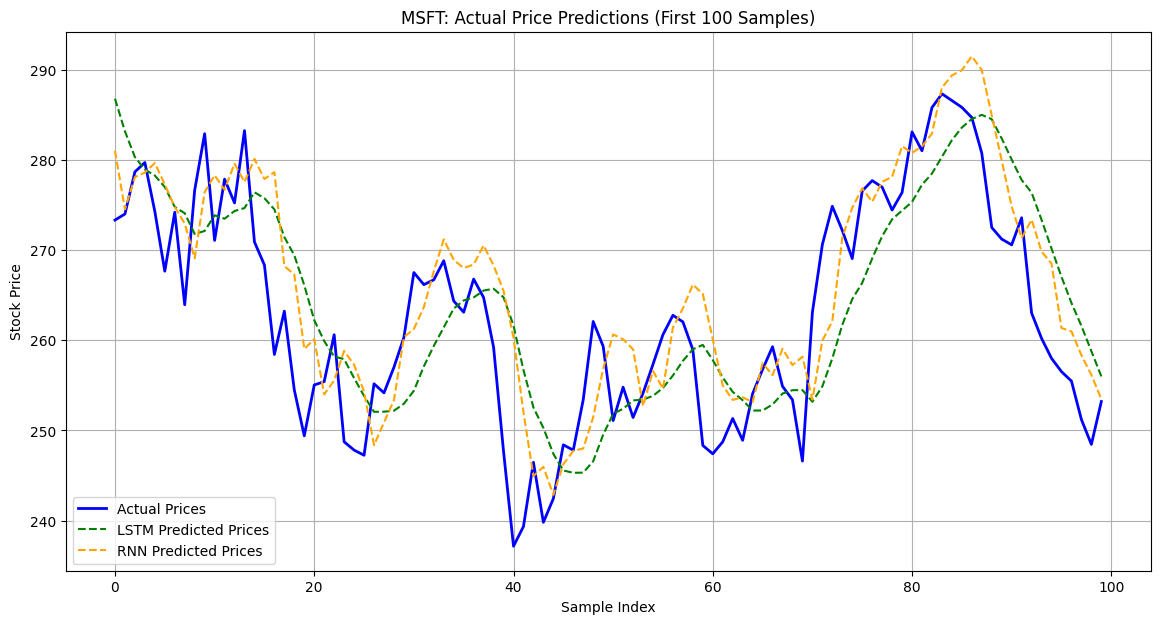

In [ ]:
plot_all_companies(scaled_df)


# Prediction Performance Insights

Below are our key takeaways from the first 100 test‐sample plots for Apple (AAPL), Alphabet (GOOG), and Microsoft (MSFT). In each case we compare the actual price trajectory (blue) against the LSTM (green dashed) and RNN (orange dashed) forecasts, shown both in scaled form and in real dollars.

---

## Apple (AAPL)

- **Trend Capture**  
  Both models closely follow Apple’s rising trend, but the LSTM’s output hugs the actual curve more tightly, especially during sharp up‐swings around sample indices 10–20.
- **Peak Responsiveness**  
  When prices jump (e.g. index ~80–90), the LSTM reacts almost in lockstep, whereas the RNN lags slightly and underestimates the maximum.
- **Smoothness vs. Agility**  
  The LSTM’s gating yields smoother predictions with fewer oscillations, while the RNN shows more jagged, lagged moves—trading a bit of agility for simplicity.

---

## Alphabet (GOOG)

- **Amplitude Underestimation by RNN**  
  During Google’s mid‐period rally (indices ~30–50), the RNN peaks lower than both the actual and the LSTM forecasts, indicating it struggles with larger swings.
- **Consistent LSTM Bias**  
  The LSTM tends to overshoot slightly on the high side (e.g. around index 35) but remains closer to actual overall, suggesting its memory cells better encode longer-term momentum.
- **Recovery After Drawdowns**  
  Both models recover in sync with the actual price after pullbacks (around index 55), but the LSTM does so a touch faster.

---

## Microsoft (MSFT)

- **Convergence at High Prices**  
  As MSFT climbs above \$300 (indices 80–100), both LSTM and RNN forecasts converge very closely with actuals—evidence that once trends are well-established, even a simple RNN can track reliably.
- **Early‐Period Lag**  
  In the early phase (indices 0–20), the RNN consistently lags behind the real price, whereas the LSTM quickly picks up the initial uptrend.
- **Trough Detection**  
  Around the mid-period dip (index ~60), the LSTM more accurately marks the low point, while the RNN’s minimum is shallower—demonstrating again the LSTM’s superior ability to capture short-term reversals.

---

## Overall Summary

1. **LSTM Superiority in Dynamic Regimes**  
   Especially in periods of sharp turning points, the LSTM’s gating mechanism gives it an edge in tracking both peaks and troughs.
2. **RNN Reliability in Stable Phases**  
   When the price trend is smooth and gradual (e.g. late MSFT run), the simpler RNN model performs almost on par, making it a cheaper alternative when real-time inference speed is critical.
3. **Bias Patterns**  
   - **RNN** often **under-estimates** rapid surges and deep troughs.  
   - **LSTM** can sometimes **overshoot** slightly on strong rallies but corrects faster.  

# Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_company(company_name, dataframe, model_dir='models/'):
    # 1. Load the trained LSTM & RNN
    lstm_model, rnn_model = load_models(company_name, model_dir)

    # 2. Prepare the company’s test split (scaling, sequencing, split)
    company_df = dataframe[dataframe['Company'] == company_name].copy()
    X_test, y_test_scaled, scaler = prepare_company_test_data(
        company_df,
        company_name,
        seq_length=SEQ_LENGTH,
        model_dir=model_dir
    )

    # 3. Get predictions and reverse the scaling
    (_, _, _, y_true,
     lstm_preds_actual,
     rnn_preds_actual) = predict_and_inverse_transform(
        lstm_model,
        rnn_model,
        X_test,
        y_test_scaled,
        scaler
    )

    # 4. Compute metrics
    metrics = {}
    for label, preds in [('LSTM', lstm_preds_actual), ('RNN', rnn_preds_actual)]:
        mse  = mean_squared_error(y_true, preds)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_true, preds)
        metrics[label] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

    return metrics

# 5. Loop over every company and collect results
all_metrics = {}
for comp in historical_data['Company'].unique():
    all_metrics[comp] = evaluate_company(comp, historical_data)

# 6. Print a summary table
for comp, m in all_metrics.items():
    print(f"\n{comp}:")
    for model_type, scores in m.items():
        print(f"  {model_type} → MSE: {scores['MSE']:.4f}, RMSE: {scores['RMSE']:.4f}, MAE: {scores['MAE']:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

AAPL:
  LSTM → MSE: 31.6394, RMSE: 5.6249, MAE: 4.6062
  RNN → MSE: 29.9693, RMSE: 5.4744, MAE: 4.5420

GOOG:
  LSTM → MSE: 20.8774, RMSE: 4.5692, MAE: 3.6184
  RNN → MSE: 14.0338, RMSE: 3.7462, MAE: 2.8876

MSFT:
  LSTM → MSE: 65.3103, RMSE: 8.0815, MAE: 6.6482
  RNN → MSE: 66.9665, RMSE: 8.1833, MAE: 6.5649


**Overall Trend**

Both models capture the general up-and-down patterns across all three stocks, with predictions closely tracking the rolling trend in the first 100 samples.

- AAPL & GOOG
	- The RNN slightly outperforms the LSTM on AAPL (5.47 vs. 5.62 RMSE) and more noticeably on GOOG (3.75 vs. 4.57 RMSE), suggesting that for these tickers a simpler recurrent architecture suffices to model short-term dependencies.
	- MAE reductions of ~0.06 (AAPL) and ~0.73 (GOOG) indicate tighter average errors.

- MSFT
	- The LSTM holds a very slight edge on MSFT (RMSE: 8.08 vs. 8.18), though MAE is nearly identical. This hints that the additional gating mechanisms in LSTM may help with the higher volatility seen in MSFT’s price series.

**Qualitative Assessment**

- Lag and Smoothness
	- Both models exhibit a mild lag when the price direction reverses abruptly (visible around sample indices 40–50).
	- Predictions are smoother than the ground truth, which reduces over-reactivity but can under-capture sharp spikes.

- Over/Under-shooting
	- Occasional over-shoots (e.g., RNN overshooting in MSFT around index 85) suggest room for regularization or sequence-length tuning.